In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once your Drive is mounted, you can load your data. Here's an example of how to load a CSV file named `your_data.csv` located in the root of your Google Drive. Please adjust the path and filename as needed.

In [4]:
import pandas as pd

# Replace 'your_data.csv' with the actual path to your file in Google Drive
data_path = '/content/drive/MyDrive/U.C/I.T_PROJECT/Datasets/Checkouts_By_Title_Data_Lens_2005.csv'

try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully!")
    display(df.head(5))
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please check the path and filename.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully!


,BibNumber,ItemBarcode,ItemType,Collection,CallNumber,CheckoutDateTime
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM


In [5]:
# === DATA CLEANING: Standardize and sanitize all input ===

# 1. Standardize column names: lowers case, strips whitespace, replaces any internal spaces with underscores.
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# 2. Remove exact duplicate rows across all columns, ensuring no redundant entries from data entry errors.
df = df.drop_duplicates()

# 3. Drop empty rows where every field is NA/missing value.
df = df.dropna(how='all')

In [6]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM


In [7]:
# 4. Keep only rows where key columns exist. Here, you require 'bibnumber' (unique item ID) and 'checkoutdatetime' (date checked out).
essential_cols = ['bibnumber', 'checkoutdatetime']
for col in essential_cols:
    if col in df.columns:
        df = df[df[col].notnull()]  # only keep rows with non-null essentials

In [8]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM


In [9]:
# 5. Parse checkoutdatetime as date; create a new column with the parsed dates. pd.to_datetime infers date formats and coerces invalid to NaT.
df['checkoutdatetime_parsed'] = pd.to_datetime(df['checkoutdatetime'], errors='coerce')

/tmp/ipython-input-2751265593.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['checkoutdatetime_parsed'] = pd.to_datetime(df['checkoutdatetime'], errors='coerce')


In [10]:
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime,checkoutdatetime_parsed
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM,2005-05-23 15:20:00
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM,2005-12-14 17:56:00
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52,2005-08-11 13:52:00
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM,2005-10-19 19:47:00
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM,2005-12-29 15:42:00


In [11]:
# 6. Remove entries with missing or non-realistic dates (filtered to years >= 1900 and dates up to today).
df = df[df['checkoutdatetime_parsed'].notnull()]
df = df[df['checkoutdatetime_parsed'] >= pd.Timestamp('1900-01-01')]
df = df[df['checkoutdatetime_parsed'] <= pd.Timestamp.today()]

In [12]:
# This optional block lets you do deeper validation on columns like barcodes (e.g., minimum length)
# if 'itembarcode' in df.columns:
#     df = df[df['itembarcode'].astype(str).str.len() >= 5]

print("Data cleaned. Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample rows:")
display(df.head())

Data cleaned. Shape: (1048575, 7)
Columns: ['bibnumber', 'itembarcode', 'itemtype', 'collection', 'callnumber', 'checkoutdatetime', 'checkoutdatetime_parsed']

Sample rows:


,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime,checkoutdatetime_parsed
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM,2005-05-23 15:20:00
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM,2005-12-14 17:56:00
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52,2005-08-11 13:52:00
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM,2005-10-19 19:47:00
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM,2005-12-29 15:42:00


In [13]:
# === FEATURE ENGINEERING AND AGGREGATION ===

# 7. Create 'year_month' field from parsed datetime for aggregation by month.
df['year_month'] = df['checkoutdatetime_parsed'].dt.to_period('M').astype(str)
# (This allows you to group checkouts by actual calendar month and track trends over time.)
df.head(5)

,bibnumber,itembarcode,itemtype,collection,callnumber,checkoutdatetime,checkoutdatetime_parsed,year_month
0,1842225,10035249209,acbk,namys,MYSTERY ELKINS1999,05/23/2005 03:20:00 PM,2005-05-23 15:20:00,2005-05
1,1928264,10037335444,jcbk,ncpic,E TABACK,12/14/2005 05:56:00 PM,2005-12-14 17:56:00,2005-12
2,1982511,10039952527,jcvhs,ncvidnf,VHS J796.2 KNOW_YO 2000,08-11-2005 13:52,2005-08-11 13:52:00,2005-08
3,2026467,10040985615,accd,nacd,CD 782.421642 Y71T,10/19/2005 07:47:00 PM,2005-10-19 19:47:00,2005-10
4,2174698,10047696215,jcbk,ncpic,E KROSOCZ,12/29/2005 03:42:00 PM,2005-12-29 15:42:00,2005-12


In [14]:
# 8. AGGREGATION: Group by 'bibnumber' (unique item ID), 'year_month', and 'itemtype' for monthly counts.
# This produces a compact table where each row is a specific item's usage for one month, possibly split by type.
group = df.groupby(['bibnumber', 'year_month', 'itemtype']).size().reset_index(name='checkouts')
group.head(5)

,bibnumber,year_month,itemtype,checkouts
0,9,2005-10,acbk,2
1,19,2005-12,acbk,1
2,31,2005-04,acbk,1
3,33,2005-05,acbk,1
4,78,2005-12,jcmus,1


In [15]:
# 9. Extract separate numeric year and month as additional features for modeling temporal effects.
group['year'] = pd.to_datetime(group['year_month'] + '-01').dt.year
group['month'] = pd.to_datetime(group['year_month'] + '-01').dt.month
group.head(5)

,bibnumber,year_month,itemtype,checkouts,year,month
0,9,2005-10,acbk,2,2005,10
1,19,2005-12,acbk,1,2005,12
2,31,2005-04,acbk,1,2005,4
3,33,2005-05,acbk,1,2005,5
4,78,2005-12,jcmus,1,2005,12


In [16]:
# 10. Prepare model features: 'year', 'month', and 'itemtype' (categorical).
# No 'title' or content-based features exist in your source, so aggregation is strictly by bibnumber, month, and type.
features = ['year', 'month', 'itemtype']
X = group[features].copy()
y = group['checkouts']


In [17]:
X.head(5)


,year,month,itemtype
0,2005,10,acbk
1,2005,12,acbk
2,2005,4,acbk
3,2005,5,acbk
4,2005,12,jcmus


In [18]:
y.head(5)

,checkouts
0,2
1,1
2,1
3,1
4,1


In [19]:
# === MODEL TRAINING SETUP ===

# 11. Split to training (80%) and testing (20%) randomly for robust evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [20]:
# 12. Preprocessing configuration:
num_cols = ['year', 'month']         # Numerical features for imputation (fill missing with median)
cat_cols = ['itemtype']              # Categorical feature for one-hot encoding

In [21]:
numeric_transformer = SimpleImputer(strategy='median')  # Fill missing numerics with median

In [22]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Fill categoricals with 'unknown'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))        # Convert all categorical types to one-hot
])

In [23]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [24]:
numeric_transformer

SimpleImputer(strategy='median')

In [25]:
categorical_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='unknown', strategy='constant')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [26]:
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['year', 'month']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['itemtype'])])

In [27]:
# 13. Fit preprocessing pipeline to training data, then transform both train and test
preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

In [28]:
X_train_p

array([[2005.,    5.,    0., ...,    0.,    0.,    0.],
       [2005.,   11.,    0., ...,    0.,    0.,    0.],
       [2005.,    9.,    0., ...,    0.,    0.,    0.],
       ...,
       [2005.,    6.,    0., ...,    0.,    0.,    0.],
       [2005.,    5.,    0., ...,    0.,    0.,    0.],
       [2005.,    9.,    0., ...,    0.,    0.,    0.]])

In [29]:
X_test_p

array([[2005.,   11.,    0., ...,    0.,    0.,    0.],
       [2005.,    4.,    0., ...,    0.,    0.,    0.],
       [2005.,   11.,    0., ...,    0.,    0.,    0.],
       ...,
       [2005.,    5.,    0., ...,    0.,    0.,    0.],
       [2005.,   12.,    0., ...,    0.,    0.,    0.],
       [2005.,    9.,    0., ...,    0.,    0.,    0.]])

In [30]:
# === MODELING AND EVALUATION ===

# 14. Train a Random Forest model on processed features
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_p, y_train)
rf_preds = rf.predict(X_test_p)

In [31]:
rf

RandomForestRegressor(n_jobs=-1, random_state=42)

In [32]:
rf_preds

array([1.02100513, 1.40542112, 3.54214619, ..., 1.35866971, 1.41598402,
       1.72135076])

In [33]:
# 15. Calculate evaluation metrics: Mean Absolute Error, Root Mean Squared Error, R-Squared
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_preds)

print("\nRandom Forest performance:")
print(f" MAE: {rf_mae:.4f}  RMSE: {rf_rmse:.4f}  R2: {rf_r2:.4f}")


Random Forest performance:
 MAE: 0.8273  RMSE: 1.5712  R2: 0.1106


In [34]:
# 16. Train a neural network (MLP) for comparison
mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
try:
    mlp.fit(X_train_p, y_train)
    mlp_preds = mlp.predict(X_test_p)
    mlp_mae = mean_absolute_error(y_test, mlp_preds)
    mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_preds))
    mlp_r2 = r2_score(y_test, mlp_preds)
    print("\nMLPRegressor performance:")
    print(f" MAE: {mlp_mae:.4f}  RMSE: {mlp_rmse:.4f}  R2: {mlp_r2:.4f}")
except Exception as e:
    print("\nMLP training failed or did not converge within iterations:", e)
    mlp_preds = None


MLPRegressor performance:
 MAE: 1.9576  RMSE: 2.2706  R2: -0.8573


In [35]:
mlp

MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

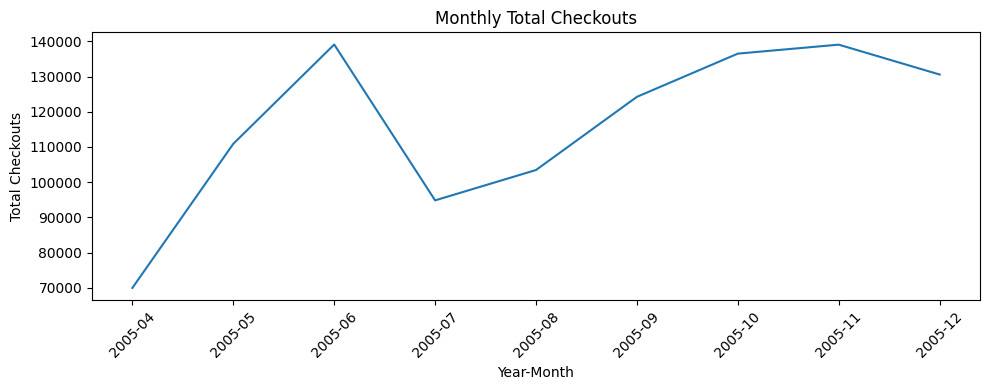

In [36]:
# === VISUALIZATION AND INTERPRETATION ===

# 17. Create a new figure for plotting the total monthly checkouts for all items combined
plt.figure(figsize=(10,4))  # Set figure size for readability
# Aggregate the total checkouts per month across the entire dataset
monthly_total = group.groupby('year_month')['checkouts'].sum().reset_index()
# Plot the checkouts over time as a line chart (trend visualization)
plt.plot(monthly_total['year_month'], monthly_total['checkouts'])
plt.title("Monthly Total Checkouts")  # Chart title for context
plt.xlabel("Year-Month")              # X-axis label
plt.ylabel("Total Checkouts")         # Y-axis label
plt.xticks(rotation=45)               # Rotate x labels for better readability
plt.tight_layout()                    # Adjust layout so axes/titles don't overlap
plt.show()                            # Display the plot

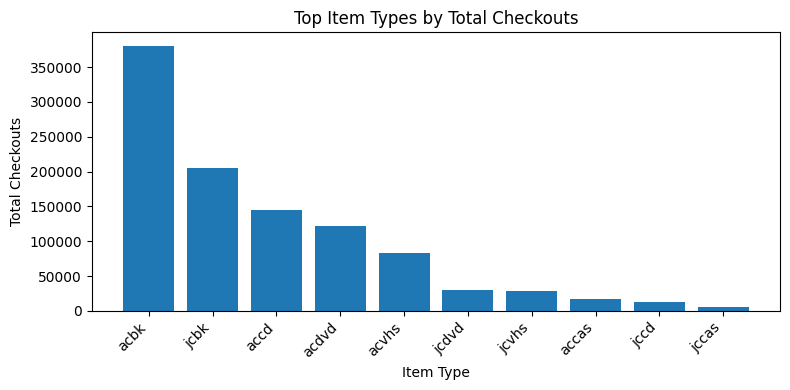

In [37]:
# 18. Bar plot for most checked out item types (top 10), helps spot most used formats
if 'itemtype' in group.columns:  # Ensure the column exists in the aggregated data
    # Compute total checkouts by item type and take the top 10 most checked out types
    top_types = group.groupby('itemtype')['checkouts'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))    # Slightly smaller figure for bar chart
    # Create a bar plot to show which item types (e.g. books, DVDs) circulate the most
    plt.bar(top_types.index, top_types.values)
    plt.title("Top Item Types by Total Checkouts")    # Chart title for context
    plt.xlabel("Item Type")                           # X-axis: the type/format of item
    plt.ylabel("Total Checkouts")                     # Y-axis: sum of checkouts for each type
    plt.xticks(rotation=45, ha='right')               # Rotate x labels for clarity
    plt.tight_layout()                                # Prevent label overlap
    plt.show()                        # Show the bar plot

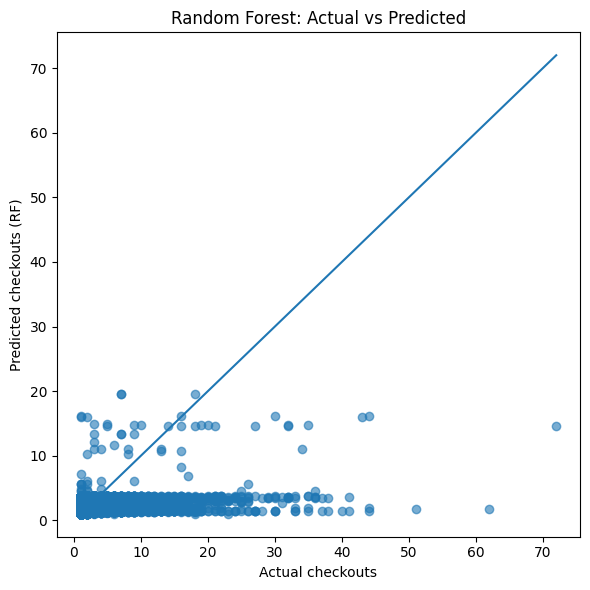

In [38]:
# 19. Scatterplot for model calibration: prediction vs reality for the Random Forest model
plt.figure(figsize=(6,6))             # Square plot for parity/accuracy
# Plot actual checkouts (y_test) vs. predicted checkouts (rf_preds) as scatter points
plt.scatter(y_test, rf_preds, alpha=0.6)
# Compute min/max of both axes to set a 45-degree reference "perfect prediction" line
minv, maxv = min(y_test.min(), rf_preds.min()), max(y_test.max(), rf_preds.max())
plt.plot([minv, maxv], [minv, maxv])  # Reference line: where prediction equals true values
plt.xlabel("Actual checkouts")        # X-axis: ground truth
plt.ylabel("Predicted checkouts (RF)")# Y-axis: model prediction
plt.title("Random Forest: Actual vs Predicted")       # Title for context
plt.tight_layout()                                   # Layout adjustment
plt.show()                                           # View calibration plot


Top permutation importances (RF):
itemtype_acdvd      0.151498
itemtype_ucfold     0.041107
itemtype_jcdvd      0.026264
itemtype_jcbk       0.019966
itemtype_acbk       0.015992
month               0.013285
itemtype_acvhs      0.012560
itemtype_accd       0.011408
itemtype_jcvhs      0.006328
itemtype_acfold     0.002549
itemtype_ucunknj    0.001555
itemtype_accas      0.001195
itemtype_jccd       0.001094
itemtype_dcillb     0.000605
itemtype_acmus      0.000335
dtype: float64


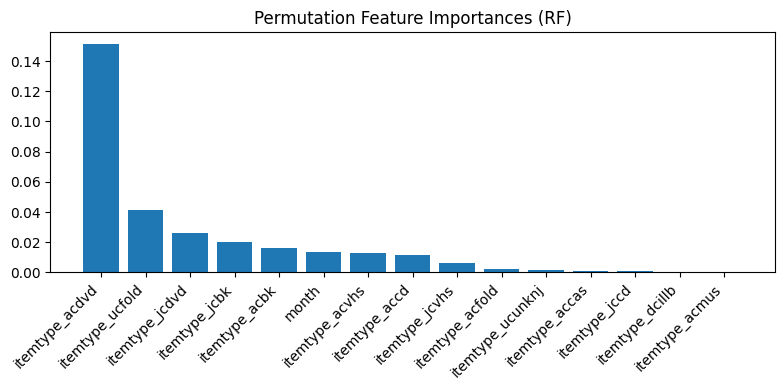

In [40]:
# 20. Permutation feature importance: visualize which features most influence Random Forest predictions
try:
    # Compute importances by how much model error increases when each feature is permuted/disrupted
    perm = permutation_importance(rf, X_test_p, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    num_features = num_cols  # List of numerical features
    # Get names of one-hot encoded categorical features after preprocessing
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names = list(num_features) + ohe_names  # Final feature name list in order
    # Build a pandas Series of average importances, sort and take top 15 for interpretability
    fi = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False).head(15)
    print("\nTop permutation importances (RF):")  # Display top features in output
    print(fi)
    plt.figure(figsize=(8,4))                  # Figure for importance bar chart
    plt.bar(fi.index, fi.values)               # Feature names vs. importance scores
    plt.xticks(rotation=45, ha='right')        # Rotate and align x labels
    plt.title("Permutation Feature Importances (RF)")    # Title for interpretation
    plt.tight_layout()                         # Prevent label overlap
    plt.show()                                 # Show bar plot
except Exception as e:
    # Handle possible permutation errors gracefully for logging/debug
    print("Permutation importance failed:", e)

In [45]:
ohe_names


['itemtype_acart',
 'itemtype_acbk',
 'itemtype_accas',
 'itemtype_accd',
 'itemtype_accdrom',
 'itemtype_acdisk',
 'itemtype_acdvd',
 'itemtype_acfold',
 'itemtype_ackit',
 'itemtype_acmus',
 'itemtype_acpam',
 'itemtype_acper',
 'itemtype_acrec',
 'itemtype_acslide',
 'itemtype_acvhs',
 'itemtype_acvid',
 'itemtype_alvhs',
 'itemtype_arbk',
 'itemtype_arcd',
 'itemtype_arcdrom',
 'itemtype_ardvd',
 'itemtype_armfc',
 'itemtype_armfm',
 'itemtype_armus',
 'itemtype_arper',
 'itemtype_arunkn',
 'itemtype_arvhs',
 'itemtype_bcbk',
 'itemtype_bccas',
 'itemtype_bccd',
 'itemtype_bccdrom',
 'itemtype_bckit',
 'itemtype_bcvhs',
 'itemtype_blvhs',
 'itemtype_dcillb',
 'itemtype_dcilll',
 'itemtype_jcbk',
 'itemtype_jccas',
 'itemtype_jccd',
 'itemtype_jccdrom',
 'itemtype_jcdvd',
 'itemtype_jckit',
 'itemtype_jcmus',
 'itemtype_jcrec',
 'itemtype_jcvhs',
 'itemtype_jlvhs',
 'itemtype_jrbk',
 'itemtype_jrvhs',
 'itemtype_ucflpdr',
 'itemtype_ucfold',
 'itemtype_ucunkn',
 'itemtype_ucunknj']

In [46]:
feature_names

['year',
 'month',
 'itemtype_acart',
 'itemtype_acbk',
 'itemtype_accas',
 'itemtype_accd',
 'itemtype_accdrom',
 'itemtype_acdisk',
 'itemtype_acdvd',
 'itemtype_acfold',
 'itemtype_ackit',
 'itemtype_acmus',
 'itemtype_acpam',
 'itemtype_acper',
 'itemtype_acrec',
 'itemtype_acslide',
 'itemtype_acvhs',
 'itemtype_acvid',
 'itemtype_alvhs',
 'itemtype_arbk',
 'itemtype_arcd',
 'itemtype_arcdrom',
 'itemtype_ardvd',
 'itemtype_armfc',
 'itemtype_armfm',
 'itemtype_armus',
 'itemtype_arper',
 'itemtype_arunkn',
 'itemtype_arvhs',
 'itemtype_bcbk',
 'itemtype_bccas',
 'itemtype_bccd',
 'itemtype_bccdrom',
 'itemtype_bckit',
 'itemtype_bcvhs',
 'itemtype_blvhs',
 'itemtype_dcillb',
 'itemtype_dcilll',
 'itemtype_jcbk',
 'itemtype_jccas',
 'itemtype_jccd',
 'itemtype_jccdrom',
 'itemtype_jcdvd',
 'itemtype_jckit',
 'itemtype_jcmus',
 'itemtype_jcrec',
 'itemtype_jcvhs',
 'itemtype_jlvhs',
 'itemtype_jrbk',
 'itemtype_jrvhs',
 'itemtype_ucflpdr',
 'itemtype_ucfold',
 'itemtype_ucunkn',
 '

In [43]:
# === SAVE ALL OUTPUTS FOR AUDIT AND SHARING ===

# 21. Output cleaned/aggregated data and model metrics as CSVs for sharing, reproducibility, or audit trail
# out_dir = "/mnt/data/i_t_project_outputs"  # Output directory
out_dir = "/content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset"
os.makedirs(out_dir, exist_ok=True)        # Ensure output directory exists
# Save per-item/month checkouts and features for traceability and future use
group.to_csv(os.path.join(out_dir, "monthly_aggregated_checkouts.csv"), index=False)
# Prepare summary of model performance metrics
metrics = {
    'model': ['RandomForest', 'MLP'],
    'MAE': [rf_mae, (mlp_mae if mlp_preds is not None else None)],
    'RMSE': [rf_rmse, (mlp_rmse if mlp_preds is not None else None)],
    'R2': [rf_r2, (mlp_r2 if mlp_preds is not None else None)]
}
metrics_df = pd.DataFrame(metrics)
# Save metrics as CSV for reporting/comparison/audit
metrics_df.to_csv(os.path.join(out_dir, "model_performance_summary.csv"), index=False)
print("\nSaved outputs to:", out_dir)          # Confirm output save location and dataset used
print("Primary dataset path used:", data_path)


Saved outputs to: /content/drive/My Drive/U.C/I.T_PROJECT/Output_Dataset
Primary dataset path used: /content/drive/MyDrive/U.C/I.T_PROJECT/Datasets/Checkouts_By_Title_Data_Lens_2005.csv


In [42]:
metrics_df

,model,MAE,RMSE,R2
0,RandomForest,0.827259,1.571233,0.110591
1,MLP,1.957611,2.270552,-0.857306
